# Dimensionality Reduction
This notebook includes the following forms of dimensionality reduction: buggy PCA, demeaned PCA, normalized PCA, DRO, and DRLV
***

In [236]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 50 samples, 2 features
X_small = pd.read_csv("data/data2D.csv",names=np.arange(0,2).tolist()).to_numpy()

# 500 samples, 1000 features
X_large = pd.read_csv("data/data1000D.csv",names=np.arange(0,1000).tolist()).to_numpy() 

***
### Functions Used in All Sections

In [2]:
def plot(X_orig, X_reconstructed, title):
    plt.scatter(X_orig[:,0],X_orig[:,1],marker='o',facecolors='none', edgecolors='b',s=20,label="Original Datapoints")
    plt.scatter(X_reconstructed[:,0],X_reconstructed[:,1], marker='x',c='r',s=20,label="Reconstructed Datapoints")
    plt.xticks(np.arange(0, 11, 1))
    plt.yticks(np.arange(0, 11, 1))
    plt.legend()
    plt.title(title,fontweight="bold");

In [3]:
def squared_sum_of_differences(X_orig, X_reconstructed):
    return np.sum(np.square(X_orig - X_reconstructed))/len(X_orig)

***
### 1. Buggy PCA

In [82]:
def buggy_pca(X, d):
    """
    param X: m x n input matrix with n-dimensions
    param d: desired dimension of reduced matrix
    
    return: tuple (eigenvalues, reconstructed matrix)
    """
    
    # store input matrix dimensions
    m,n = X.shape
    
    # SVD of X
    U, s, V = np.linalg.svd(X)
    eigenvalues = s[0:d]**2
    
    # low dimensional representation of X
    Z = np.dot(X,V[0:d].T)
    
    # reduced version of X
    X_r = np.dot(Z.reshape(m,d),V[0:d].reshape(d,n))
    
    return (eigenvalues, X_r)

In [84]:
eigenvalues, X_r = buggy_pca(X=X_small, d=1)
buggy_pca_ssd = squared_sum_of_differences(X_small, X_r)
print("Squared Sum of Differences: %.6f"%buggy_pca_ssd)

Squared Sum of Differences: 0.886903


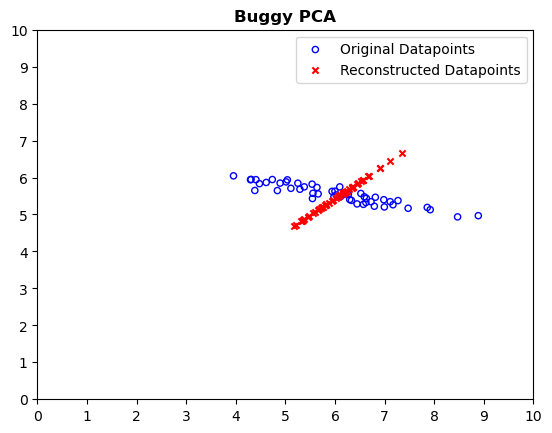

In [85]:
plot(X_small, X_r, "Buggy PCA")

***
### 2. Demeaned PCA

In [94]:
def demeaned_pca(X, d):
    """
    param X: m x n input matrix with n-dimensions
    param d: desired dimension of reduced matrix
    
    return: tuple (eigenvalues, reconstructed matrix)
    """
    
    # store input matrix dimensions
    m,n = X.shape

    # subtract each dimension by its corresponding mean
    X_mean = X - X.mean(axis=0)
    
    
    # SVD of X
    U, s, V = np.linalg.svd(X_mean)
    eigenvalues = s[0:d]**2
    
    # low dimensional representation of X
    Z = np.dot(X_mean,V[0:d].T)
    
    # reduced version of X
    X_r = np.dot(Z.reshape(m,d),V[0:d].reshape(d,n)) + X.mean(axis=0)
    
    return (eigenvalues, X_r)

In [95]:
eigenvalues, X_r = demeaned_pca(X=X_small, d=1)
demeaned_pca_ssd = squared_sum_of_differences(X_small, X_r)
print("Squared Sum of Differences: %.6f"%demeaned_pca_ssd)

Squared Sum of Differences: 0.010006


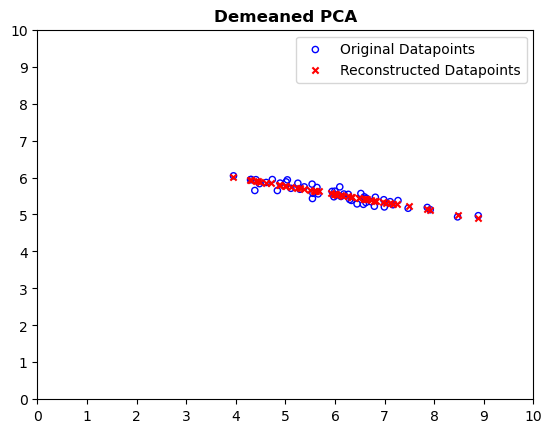

In [96]:
plot(X_small, X_r, "Demeaned PCA")

***
### 3. Normalized PCA

In [98]:
def normalized_pca(X, d):
    """
    param X: m x n input matrix with n-dimensions
    param d: desired dimension of reduced matrix
    
    return: tuple (eigenvalues, reconstructed matrix)
    """
    
    # store input matrix dimensions
    m,n = X.shape

    # normalized the data
    X_mean = (X - X.mean(axis=0))
    X_sigma = np.sqrt(np.sum(np.square(X_mean),axis=0)/len(X))
    X_norm = X_mean / X_sigma
    
    # SVD of X
    U, s, V = np.linalg.svd(X_norm)
    eigenvalues = s[0:d]**2
    
    # low dimensional representation of X
    Z = np.dot(X_norm,V[0:d].T)
    
    # reduced version of X
    X_r = (np.dot(Z.reshape(m,d),V[0:d].reshape(d,n))*X_sigma) + X.mean(axis=0)
    
    return (eigenvalues, X_r)

In [99]:
eigenvalues, X_r = normalized_pca(X=X_small, d=1)
normalized_pca_ssd = squared_sum_of_differences(X_small, X_r)
print("Squared Sum of Differences: %.6f"%normalized_pca_ssd)

Squared Sum of Differences: 0.049472


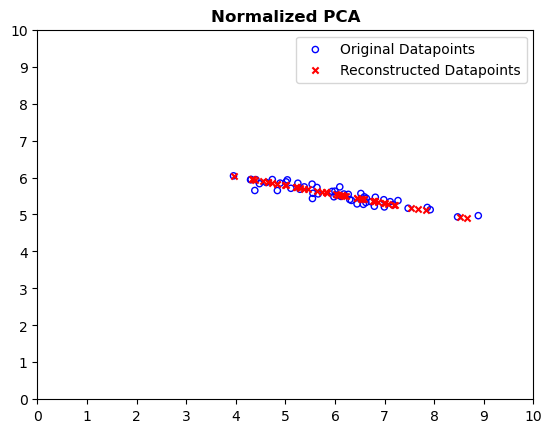

In [100]:
plot(X_small, X_r, "Normalized PCA")

***
### 4. DRO

In [175]:
def DRO(X, d):
    """
    param X: m x n input matrix with n-dimensions
    param d: desired dimension of reduced matrix
    
    return: tuple (eigenvalues, reconstructed matrix)
    """
    
    # store input matrix dimensions
    m,n = X.shape

    # eigen decomp
    X_mean = (X - X.mean(axis=0))
    eigenvalues, eigenvectors = np.linalg.eig(np.cov(X_mean.T))
    
    # sort eigenvector & eigenvalue pairs
    sorted_indices = np.argsort(-np.abs(eigenvalues))
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = -1*eigenvectors[:, sorted_indices]

    # low dimensional representation of X
    Z = np.dot(X_mean,eigenvectors.T[0:d].T)
    
    # reduced version of X
    X_r = np.dot(Z.reshape(m,d),eigenvectors.T[0:d].reshape(d,n)) + X.mean(axis=0)
    
    return (eigenvalues, eigenvectors, X_r)

In [176]:
(eigenvalues, eigenvectors, X_r) = DRO(X=X_small, d=1)
dro_ssd = squared_sum_of_differences(X_small, X_r)
print("Squared Sum of Differences: %.6f"%dro_ssd)

Squared Sum of Differences: 0.010006


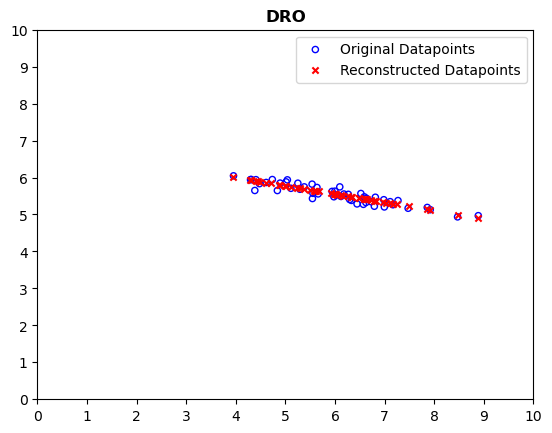

In [177]:
plot(X_small, X_r, "DRO")

### Choosing d for 1000-d Dataset Using "Knee Point"

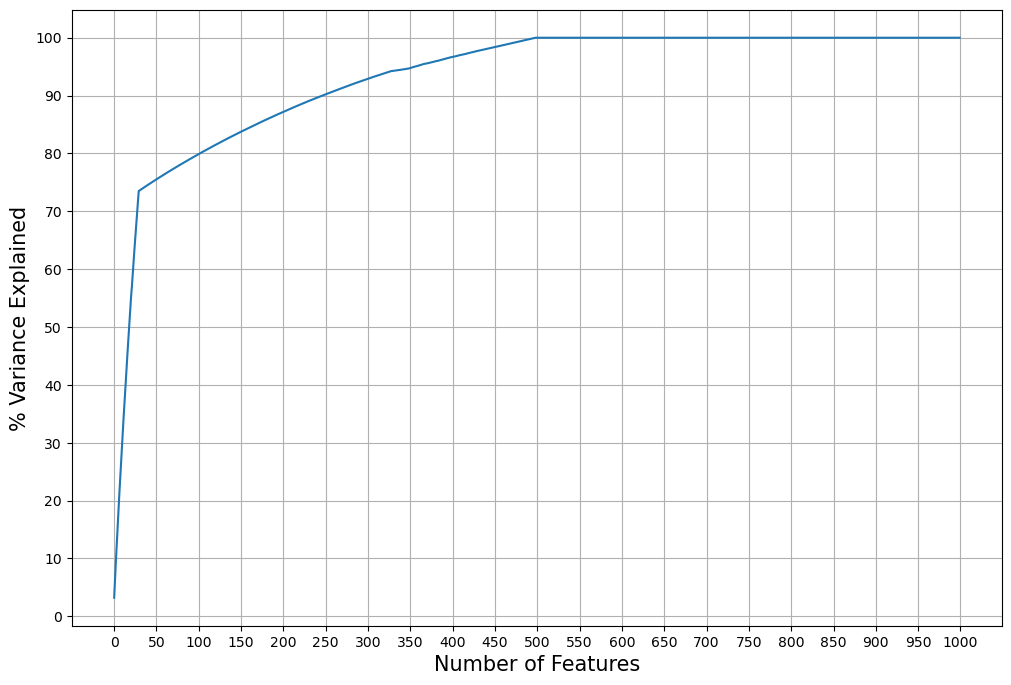

In [246]:
# observe the singular values in DRO and see if there is a clear knee point
X_mean = (X_large - X_large.mean(axis=0))
eigenvalues, eigenvectors = np.linalg.eig(np.cov(X_mean.T))
s = np.nan_to_num(np.sqrt(eigenvalues.real))
sum_singular_values = sum(s)
singular_value_proportions = []
for s_i in s:
    singular_value_proportions.append(s_i / sum_singular_values)
cumulative_singular_value_proportions = np.cumsum(singular_value_proportions)

# plotting
plt.figure(figsize=(12, 8))
plt.xticks(np.arange(0,1025,50))
plt.yticks(np.arange(0,101,10))
plt.grid()
plt.ylabel("% Variance Explained",fontsize=15)
plt.xlabel("Number of Features",fontsize=15)
plt.plot(cumulative_singular_value_proportions*100);

In [247]:
(eigenvalues, X_r) = buggy_pca(X=X_large, d=500)
buggy_pca_ssd_1k = squared_sum_of_differences(X_large, X_r)
print("Squared Sum of Differences:",buggy_pca_ssd_1k)

Squared Sum of Differences: 1.0015417751388312e-24


In [248]:
(eigenvalues, X_r) = demeaned_pca(X=X_large, d=500)
demeaned_pca_ssd_1k = squared_sum_of_differences(X_large, X_r)
print("Squared Sum of Differences:",demeaned_pca_ssd_1k)

Squared Sum of Differences: 1.2550014058502036e-25


In [249]:
(eigenvalues, X_r) = normalized_pca(X=X_large, d=500)
normalized_pca_ssd_1k = squared_sum_of_differences(X_large, X_r)
print("Squared Sum of Differences:",normalized_pca_ssd_1k)

Squared Sum of Differences: 1.5799531827014428e-25


In [250]:
(eigenvalues, eigenvectors, X_r) = DRO(X=X_large, d=500)
dro_ssd_1k = squared_sum_of_differences(X_large, X_r.real)
print("Squared Sum of Differences:",dro_ssd_1k)

Squared Sum of Differences: 3.1847904506454315e-21


### Printing  Squared Sum of Differences

In [253]:
print("Reconstruction Errors 2-d Dataset:")
print("\tBuggy PCA: %.8f" % buggy_pca_ssd)
print("\tDemeaned PCA: %.8f" % demeaned_pca_ssd)
print("\tNormalized PCA: %.8f" % normalized_pca_ssd)
print("\tDRO: %.8f" % dro_ssd)

print("\nReconstruction Errors 1000-d Dataset:")
print("\tBuggy PCA:", buggy_pca_ssd_1k)
print("\tDemeaned PCA:", demeaned_pca_ssd_1k)
print("\tNormalized PCA:", normalized_pca_ssd_1k)
print("\tDRO:", dro_ssd_1k)

Reconstruction Errors 2-d Dataset:
	Buggy PCA: 0.88690308
	Demeaned PCA: 0.01000609
	Normalized PCA: 0.04947208
	DRO: 0.01000609

Reconstruction Errors 1000-d Dataset:
	Buggy PCA: 1.0015417751388312e-24
	Demeaned PCA: 1.2550014058502036e-25
	Normalized PCA: 1.5799531827014428e-25
	DRO: 3.1847904506454315e-21
